Исходные данные были получены в нескольких файлах, с лишними записями и признаками. 

В этом ноутбуке производится очистка и подготовка данных для загрузки в базу.

In [74]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### Предобработка данных отправлений

In [95]:
#считываем каждый файл из папки, складываем в массив датафреймов
dfs_dep = []
dfs_dep.append(pd.read_csv('departures/Detailed_Statistics_Departures.csv'))

for i in range(2, 25):
    path = 'departures/Detailed_Statistics_Departures-' + str(i) + '.csv'
    dfs_dep.append(pd.read_csv(path))
    
#конкатенируем все датафреймы в один
all_departures = pd.concat(dfs_dep)

In [77]:
len(all_departures)

3272931

В данных могут быть дубликаты - уберем их

In [78]:
all_departures = all_departures.drop_duplicates()

In [79]:
len(all_departures)

2653114

Дубликаты действительно были.

In [96]:
all_departures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3272931 entries, 0 to 684707
Data columns (total 17 columns):
 #   Column                                    Dtype 
---  ------                                    ----- 
 0   Carrier Code                              object
 1   Date (MM/DD/YYYY)                         object
 2   Flight Number                             int64 
 3   Tail Number                               object
 4   Destination Airport                       object
 5   Scheduled departure time                  object
 6   Actual departure time                     object
 7   Scheduled elapsed time (Minutes)          int64 
 8   Actual elapsed time (Minutes)             int64 
 9   Departure delay (Minutes)                 int64 
 10  Wheels-off time                           object
 11  Taxi-Out time (Minutes)                   int64 
 12  Delay Carrier (Minutes)                   int64 
 13  Delay Weather (Minutes)                   int64 
 14  Delay National Avia

Оставим только нужные нам колонки

In [97]:
all_departures = all_departures[['Carrier Code', 
                                 'Date (MM/DD/YYYY)', 
                                 'Flight Number', 
                                 'Destination Airport', 
                                 'Scheduled departure time', 
                                 'Departure delay (Minutes)']]

In [98]:
all_departures.reset_index(drop=True)

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Destination Airport,Scheduled departure time,Departure delay (Minutes)
0,VX,01/01/2012,201,SFO,07:00,3
1,VX,01/01/2012,233,LAX,15:50,12
2,VX,01/01/2012,811,LAX,08:40,0
3,VX,01/01/2012,815,LAX,18:30,27
4,VX,01/01/2012,837,SFO,14:05,-2
...,...,...,...,...,...,...
3272926,UA,12/31/2021,2669,EWR,15:45,0
3272927,UA,12/31/2021,2677,IAD,13:00,-5
3272928,UA,12/31/2021,2678,IAH,12:45,10
3272929,UA,12/31/2021,2682,IAH,14:05,1


Мы в команде договорились об определенном названии и формате колонок - чтобы онлайн поступающие данные не конфликтовали. Приведем наши датасеты в такой вид

In [99]:
all_departures['Date'] = pd.to_datetime(all_departures['Date (MM/DD/YYYY)'])
all_departures = all_departures.drop(columns = ['Date (MM/DD/YYYY)'])

#переименуем колонки
all_departures = all_departures.rename(columns={"Flight Number":"Flight",
                                                "Destination Airport" : "Destination airport",
                                                "Scheduled departure time" : "Scheduled time",
                                                 "Departure delay (Minutes)" : "Delay"})

Так как наша модель будет учиться на данных за год - отрежем лишние данные и сэкономим место

In [86]:
all_departures = all_departures[all_departures.Date >= pd.to_datetime('2021-11-01')]

Добавим колонку Datetime. Она будет не очень полезна для обучения модели, но нужна для склейки данных вылета с данными погоды

In [88]:
all_departures['Datetime'] = pd.to_datetime(
    all_departures['Date'].astype(str) + ' ' + all_departures['Scheduled time'].astype(str))

Посмотрим, сколько строк нужно будет сложить в базу

In [89]:
len(all_departures)

264272

Это адекватное количество, наша база с этим справится. Последний раз посмотрим на данные:

In [92]:
all_departures = all_departures.reset_index(drop=True)
all_departures

,Carrier Code,Flight,Destination airport,Scheduled time,Delay,Date,Datetime
0,AS,27,SEA,09:45,159,2022-01-01,2022-01-01 09:45:00
1,AS,39,SEA,17:29,23,2022-01-01,2022-01-01 17:29:00
2,AS,139,ANC,07:05,115,2022-01-01,2022-01-01 07:05:00
3,AS,1011,SEA,07:45,3,2022-01-01,2022-01-01 07:45:00
4,AS,1013,SEA,15:35,37,2022-01-01,2022-01-01 15:35:00
...,...,...,...,...,...,...,...
264267,UA,2669,EWR,15:45,0,2021-12-31,2021-12-31 15:45:00
264268,UA,2677,IAD,13:00,-5,2021-12-31,2021-12-31 13:00:00
264269,UA,2678,IAH,12:45,10,2021-12-31,2021-12-31 12:45:00
264270,UA,2682,IAH,14:05,1,2021-12-31,2021-12-31 14:05:00


Убедимся, что пробелов в данных нет

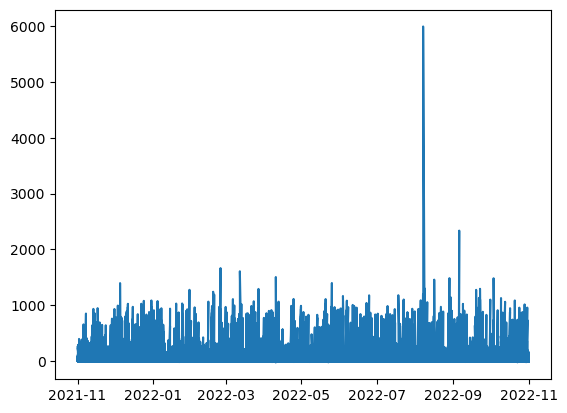

In [94]:
plt.plot(all_departures.Datetime, all_departures.Delay)

И сохраним в файл, который потом загрузим в базу

In [93]:
all_departures.to_csv("Delays_historical.csv")

### Предобработка данных погоды


 Так же, как и с отправлениями, считываем файлы в массив датафреймов и склеиваем в один датафрейм

In [103]:
dfs_weather = []
dfs_weather.append(pd.read_csv('weather/weather 1.csv'))
for i in range(2, 15):
    path = 'weather/weather ' + str(i) + '.csv'
    dfs_weather.append(pd.read_csv(path))

all_weather = pd.concat(dfs_weather)

In [104]:
len(all_weather)

10753

Попробуем убрать дубликаты

In [106]:
all_weather = all_weather.drop_duplicates()
len(all_weather)

10753

Их не было

In [107]:
all_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10753 entries, 0 to 983
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              10009 non-null  object 
 1   datetime          10753 non-null  object 
 2   temp              10753 non-null  float64
 3   feelslike         10753 non-null  float64
 4   dew               10753 non-null  float64
 5   humidity          10753 non-null  float64
 6   precip            10753 non-null  float64
 7   precipprob        10753 non-null  float64
 8   preciptype        1072 non-null   object 
 9   snow              10674 non-null  float64
 10  snowdepth         10753 non-null  float64
 11  windgust          9360 non-null   float64
 12  windspeed         10753 non-null  float64
 13  winddir           10753 non-null  float64
 14  sealevelpressure  10753 non-null  float64
 15  cloudcover        10753 non-null  float64
 16  visibility        10753 non-null  float64


Приведем данные нужному виду: уберем лишние колонки и приведем к нужному типу

In [ ]:
all_weather = all_weather.drop(columns=['stations', 'name'])
all_weather['datetime'] = pd.to_datetime(all_weather.datetime)
all_weather = all_weather.sort_values(by=['datetime'])

In [109]:
all_weather.reset_index(drop=True)

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,O'Hare Chicago,2021-11-01T00:00:00,39.8,34.5,29.7,66.84,0.0,0.0,NaN,0.0,...,1022.3,0.0,9.9,NaN,NaN,NaN,NaN,Clear,clear-night,"72534014819,KORD,72530094846,KMDW,74466504838,..."
1,O'Hare Chicago,2021-11-01T01:00:00,39.0,33.5,28.9,66.93,0.0,0.0,NaN,0.0,...,1022.7,0.0,9.9,NaN,NaN,NaN,NaN,Clear,clear-night,"72534014819,KORD,72530094846,KMDW,74466504838,..."
2,O'Hare Chicago,2021-11-01T02:00:00,38.2,32.9,28.9,68.76,0.0,0.0,NaN,0.0,...,1022.8,0.0,9.9,NaN,NaN,NaN,NaN,Clear,clear-night,"72534014819,KORD,72530094846,KMDW,74466504838,..."
3,O'Hare Chicago,2021-11-01T03:00:00,37.3,31.9,28.9,71.23,0.0,0.0,NaN,0.0,...,1023.2,0.0,9.9,NaN,NaN,NaN,NaN,Clear,clear-night,"72534014819,KORD,72530094846,KMDW,74466504838,..."
4,O'Hare Chicago,2021-11-01T04:00:00,37.2,31.9,28.9,71.76,0.0,0.0,NaN,0.0,...,1023.6,0.0,9.9,NaN,NaN,NaN,NaN,Clear,clear-night,"72534014819,KORD,72530094846,KMDW,74466504838,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10748,O'hare Chicago,2022-12-21T19:00:00,-0.7,-3.1,-3.9,78.45,0.0,0.0,NaN,0.0,...,1024.0,100.0,11.3,0.0,NaN,0.0,10.0,Overcast,cloudy,"72534014819,KORD,72530094846,KMDW,74466504838,..."
10749,O'hare Chicago,2022-12-21T20:00:00,-0.7,-4.2,-3.9,78.42,0.0,0.0,NaN,0.0,...,1022.6,97.4,11.2,0.0,NaN,0.0,10.0,Overcast,cloudy,"72534014819,KORD,72530094846,KMDW,74466504838,..."
10750,O'hare Chicago,2022-12-21T21:00:00,-0.6,-3.2,-3.3,81.90,0.0,0.0,NaN,0.0,...,1021.6,96.5,10.9,0.0,NaN,0.0,10.0,Overcast,cloudy,"72534014819,KORD,72530094846,KMDW,74466504838,..."
10751,O'hare Chicago,2022-12-21T22:00:00,0.0,-3.5,-3.3,78.66,0.0,0.0,NaN,0.0,...,1020.9,100.0,10.9,0.0,NaN,0.0,10.0,Overcast,cloudy,"72534014819,KORD,72530094846,KMDW,74466504838,..."


Убедимся, что данные есть за все нужные даты

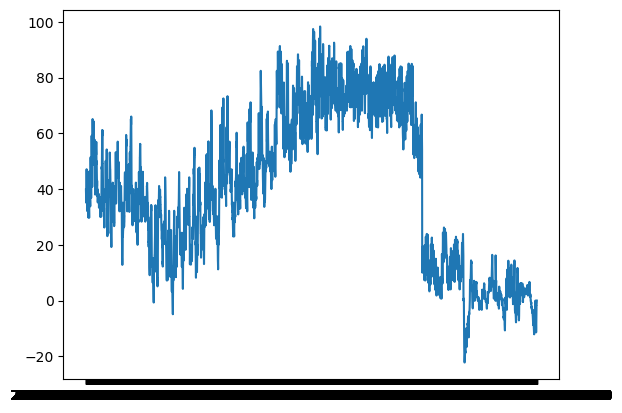

In [110]:
plt.plot(all_weather.datetime, all_weather.temp)

И сохраним в файл, который загрузим в базу

In [111]:
all_weather.to_csv("weather_historical.csv")